In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cosima_cookbook as cc
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:35637 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 155.69 GB


In [4]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def southern_ocean(ds):
    ds = ds.sel(yu_ocean = slice(None, -50))
    return ds

def southern_ocean_plot():
    fig = plt.figure(1, figsize = (16, 12))
    ax1 = fig.add_axes([0.0, 0.5, 0.5, 0.5], projection = ccrs.SouthPolarStereo())
    ax1.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform = ax1.transAxes)
    
    ax2 = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection = ccrs.SouthPolarStereo())
    ax2.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax2.set_boundary(circle, transform = ax2.transAxes)
    
    ax3 = fig.add_axes([0.1, 0.43, 0.3, 0.02])
    ax4 = fig.add_axes([0.53, 0.43, 0.3, 0.02])
    plt.tight_layout()
    return fig, [ax1, ax2, ax3, ax4]

In [5]:
hu = xr.open_dataset('/scratch/e14/jn8053/misc/hu-01deg.nc')['hu']

# Ocean surface stress $\tau$ (wind + ice) 

Total surface stress ($\tau_x$ and $\tau_y$) are calculated from the relative ice/ocean, air/ocean stresses, weighted by sea ice concentration:

$$
\tau = \alpha \tau_{ice/ocean} + (1 - \alpha) \tau_{air/ocean}
$$

In [6]:
files_ryf = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easup = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easdo = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_down10//output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]

In [7]:
example = xr.open_dataset(files_ryf[0])
drop = [i for i in example.variables]
drop.remove('tau_x')
drop.remove('tau_y')
drop.remove('xu_ocean')
drop.remove('yu_ocean')
drop.remove('time')

In [8]:
tau_ryf = xr.open_mfdataset(files_ryf, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
tau_up = xr.open_mfdataset(files_easup, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
tau_down = xr.open_mfdataset(files_easdo, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)

In [9]:
tau_ryf['tau_x']

<xarray.DataArray 'tau_x' (time: 180, yu_ocean: 665, xu_ocean: 3600)>
dask.array<concatenate, shape=(180, 665, 3600), dtype=float32, chunksize=(3, 665, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2150-01-16 12:00:00 ... 2164-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -50.19 -50.12 -50.06
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  surface_downward_x_stress

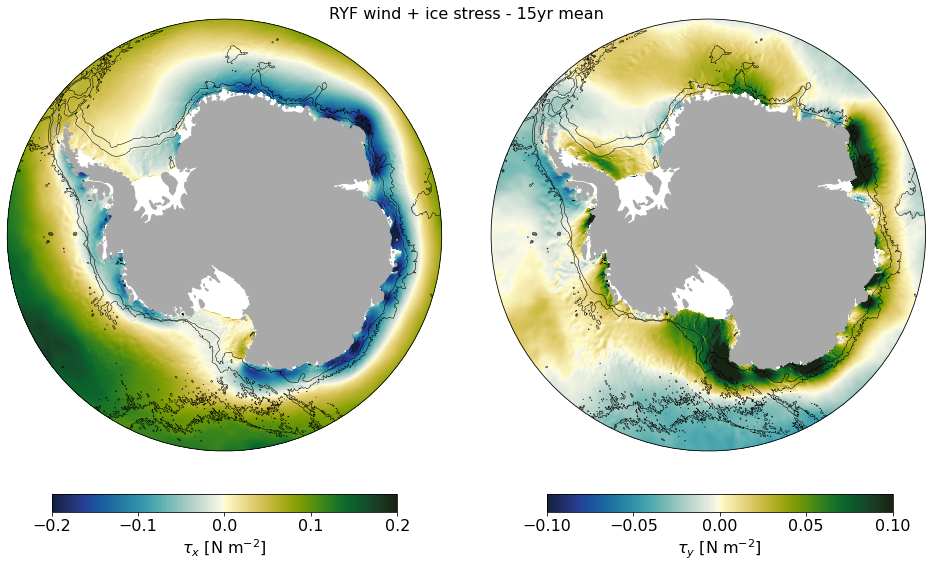

In [18]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'RYF wind + ice stress - 15yr mean', fontsize = 16, ha = 'center')
cf = axs[0].pcolormesh(tau_ryf['xu_ocean'], tau_ryf['yu_ocean'], tau_ryf['tau_x'].mean('time'), 
                       vmin = -0.2, vmax = 0.2, cmap = cmocean.cm.delta, transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_x$ [N m$^{-2}$]')

cf = axs[1].pcolormesh(tau_ryf['xu_ocean'], tau_ryf['yu_ocean'], tau_ryf['tau_y'].mean('time'), 
                       vmin = -0.1, vmax = 0.1, cmap = cmocean.cm.delta, transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_y$ [N m$^{-2}$]')

plt.tight_layout()
plt.savefig(figdir+'easterlies-collaborative/tau_xy-ryf-mean.png')

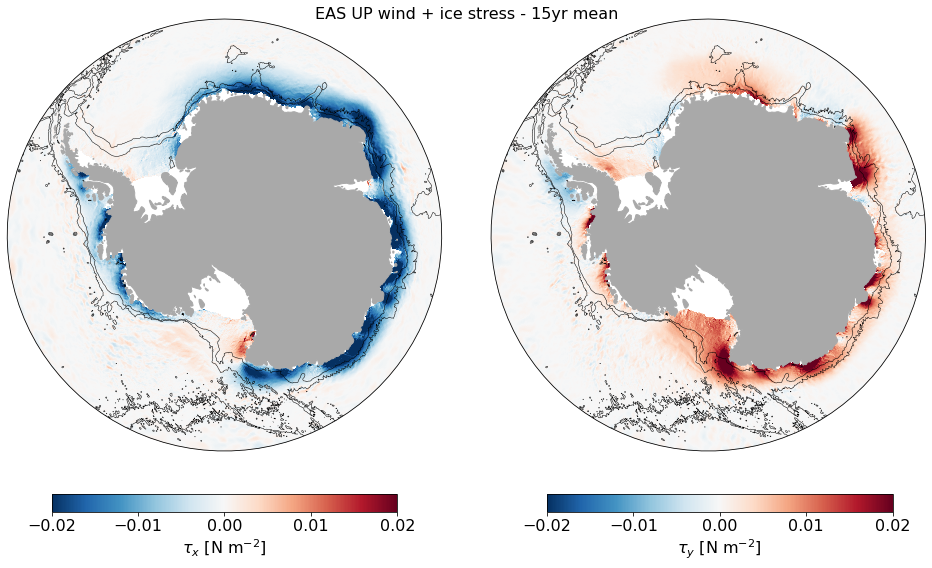

In [22]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'EAS UP wind + ice stress - 15yr mean', fontsize = 16, ha = 'center')
cf = axs[0].pcolormesh(tau_up['xu_ocean'], tau_up['yu_ocean'], tau_up['tau_x'].mean('time') - tau_ryf['tau_x'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_x$ [N m$^{-2}$]')

cf = axs[1].pcolormesh(tau_up['xu_ocean'], tau_up['yu_ocean'], tau_up['tau_y'].mean('time') - tau_ryf['tau_y'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_y$ [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy-easup-mean.png')

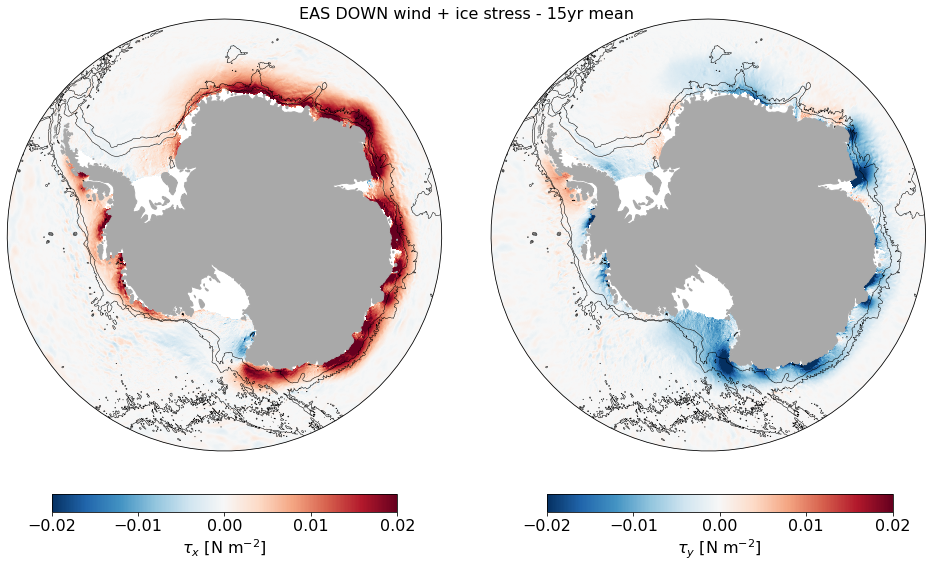

In [23]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'EAS DOWN wind + ice stress - 15yr mean', fontsize = 16, ha = 'center')
cf = axs[0].pcolormesh(tau_down['xu_ocean'], tau_down['yu_ocean'], tau_down['tau_x'].mean('time') - tau_ryf['tau_x'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_x$ [N m$^{-2}$]')

cf = axs[1].pcolormesh(tau_down['xu_ocean'], tau_down['yu_ocean'], tau_down['tau_y'].mean('time') - tau_ryf['tau_y'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_y$ [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy-easdown-mean.png')

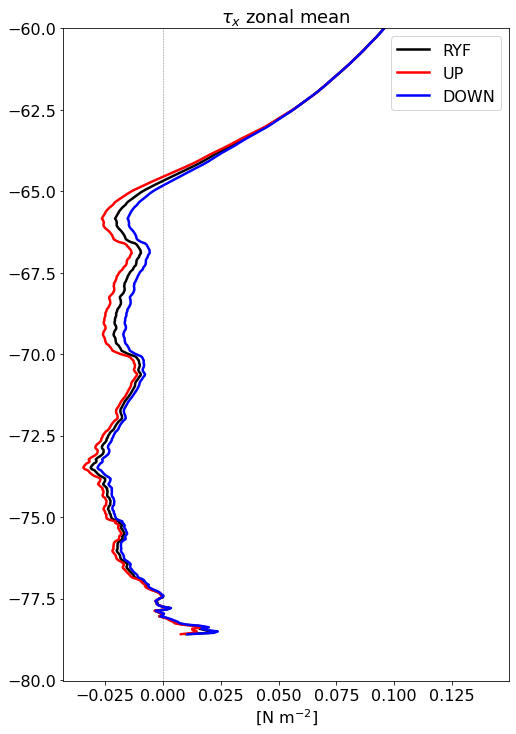

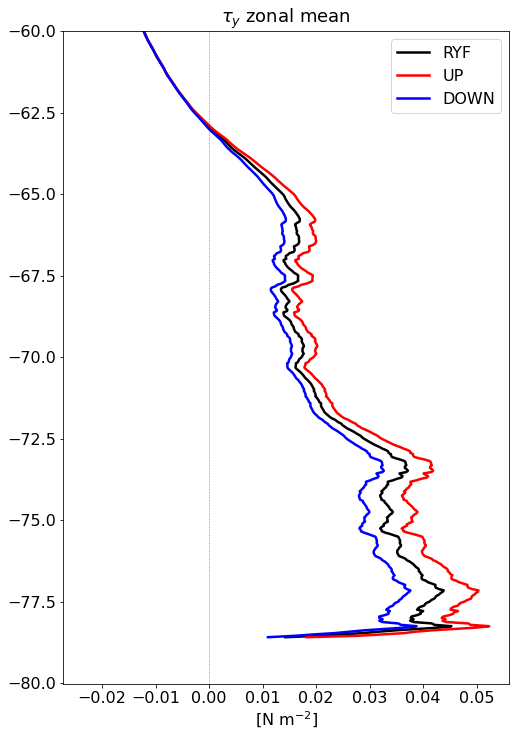

In [21]:
fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.plot(tau_ryf['tau_x'].mean('time').mean('xu_ocean'), tau_ryf['yu_ocean'], color = 'k', linewidth = 2.5, label = 'RYF')
axs.plot(tau_up['tau_x'].mean('time').mean('xu_ocean'), tau_up['yu_ocean'], color = 'r', linewidth = 2.5, label = 'UP')
axs.plot(tau_down['tau_x'].mean('time').mean('xu_ocean'), tau_down['yu_ocean'], color = 'b', linewidth = 2.5, label = 'DOWN')
axs.set_ylim(None, -60)
axs.set_xlabel('[N m$^{-2}$]')
plt.legend()
plt.title('$\\tau_x$ zonal mean', fontsize = 18)
plt.savefig(figdir+'/easterlies-collaborative/tau_x_zonal_mean.png')

fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.plot(tau_ryf['tau_y'].mean('time').mean('xu_ocean'), tau_ryf['yu_ocean'], color = 'k', linewidth = 2.5, label = 'RYF')
axs.plot(tau_up['tau_y'].mean('time').mean('xu_ocean'), tau_up['yu_ocean'], color = 'r', linewidth = 2.5, label = 'UP')
axs.plot(tau_down['tau_y'].mean('time').mean('xu_ocean'), tau_down['yu_ocean'], color = 'b', linewidth = 2.5, label = 'DOWN')
plt.title('$\\tau_y$ zonal mean', fontsize = 18)
axs.set_ylim(None, -60)
axs.set_xlabel('[N m$^{-2}$]')
plt.legend()
plt.savefig(figdir+'/easterlies-collaborative/tau_y_zonal_mean.png')

# Wind stress (from JRA55 input)

In [24]:
keys = ['ryf', 'up', 'down']

In [25]:
u = {}
v = {}
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
u['ryf'] = xr.open_dataset(u_file, decode_times = False)['uas_10m']
v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'
v['ryf'] = xr.open_dataset(v_file, decode_times = False)['vas_10m']
u_file_up = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.u_10.1990_1991.nc'
u['up'] = xr.open_dataset(u_file_up, decode_times = False)['uas_10m']
v_file_up = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.v_10.1990_1991.nc'
v['up'] = xr.open_dataset(v_file_up,decode_times = False)['vas_10m']
u_file_do = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.u_10.1990_1991.nc'
u['down'] = xr.open_dataset(u_file_do, decode_times = False)['uas_10m']
v_file_do = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.v_10.1990_1991.nc'
v['down'] = xr.open_dataset(v_file_do,decode_times = False)['vas_10m']

In [26]:
ws = {}
tau_x = {}
tau_y = {}
for k in keys:
    # Wind speed
    ws[k] = np.sqrt(u[k]**2 + v[k]**2)
    # Drag coefficient
    cd = (2.70/ws[k] + 0.142 + ws[k]/13.09)/1000
    # Wind stress
    tau_x[k] = 1.22 * cd * u[k] * ws[k]
    tau_y[k] = 1.22 * cd * v[k] * ws[k]

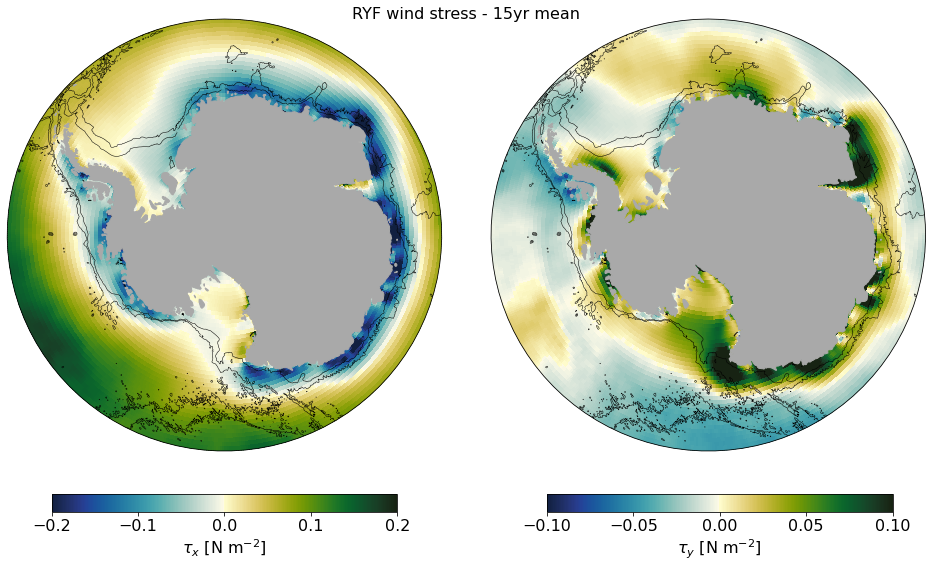

In [27]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'RYF wind stress - 15yr mean', fontsize = 16, ha = 'center')
cf = axs[0].pcolormesh(tau_x['ryf']['longitude'], tau_x['ryf']['latitude'], tau_x['ryf'].mean('time'), 
                       vmin = -0.2, vmax = 0.2, cmap = cmocean.cm.delta, transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_x$ [N m$^{-2}$]')

cf = axs[1].pcolormesh(tau_y['ryf']['longitude'], tau_y['ryf']['latitude'], tau_y['ryf'].mean('time'), 
                       vmin = -0.1, vmax = 0.1, cmap = cmocean.cm.delta, transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_y$ [N m$^{-2}$]')

plt.tight_layout()
plt.savefig(figdir+'easterlies-collaborative/tau_xy_wind-ryf-mean.png')

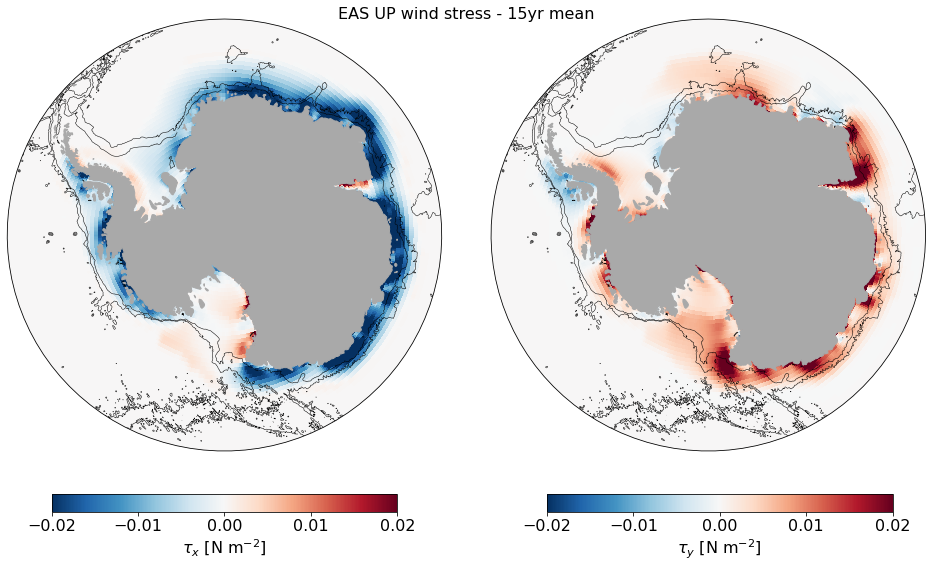

In [28]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'EAS UP wind stress - 15yr mean', fontsize = 16, ha = 'center')
cf = axs[0].pcolormesh(tau_x['up']['longitude'], tau_x['up']['latitude'], tau_x['up'].mean('time') - tau_x['ryf'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_x$ [N m$^{-2}$]')

cf = axs[1].pcolormesh(tau_y['up']['longitude'], tau_y['up']['latitude'], tau_y['up'].mean('time') - tau_y['ryf'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_y$ [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy_wind-easup-mean.png')

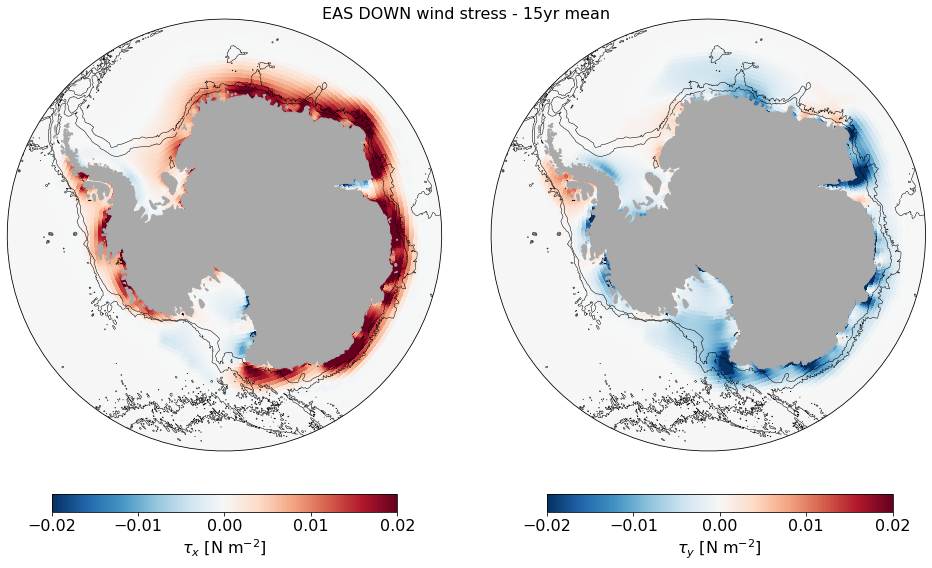

In [29]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'EAS DOWN wind stress - 15yr mean', ha = 'center')
cf = axs[0].pcolormesh(tau_x['down']['longitude'], tau_x['down']['latitude'], tau_x['down'].mean('time') - tau_x['ryf'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_x$ [N m$^{-2}$]')

cf = axs[1].pcolormesh(tau_y['down']['longitude'], tau_y['down']['latitude'], tau_y['down'].mean('time') - tau_y['ryf'].mean('time'), 
                       vmin = -0.02, vmax = 0.02, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('$\\tau_y$ [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy_wind-easdown-mean.png')

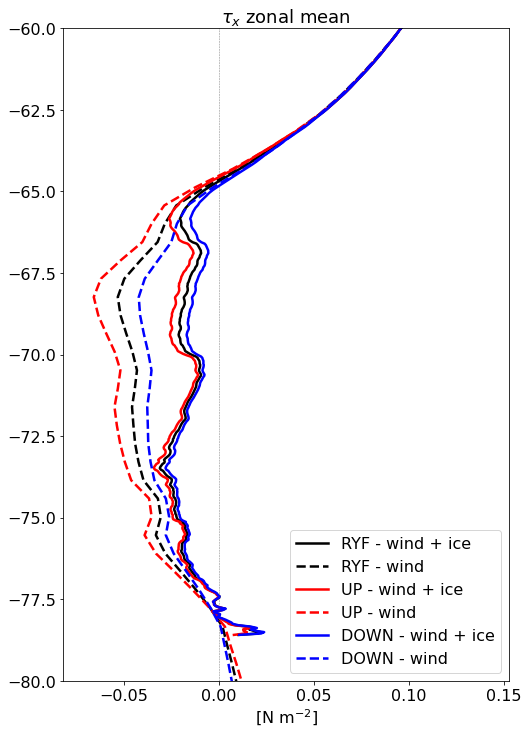

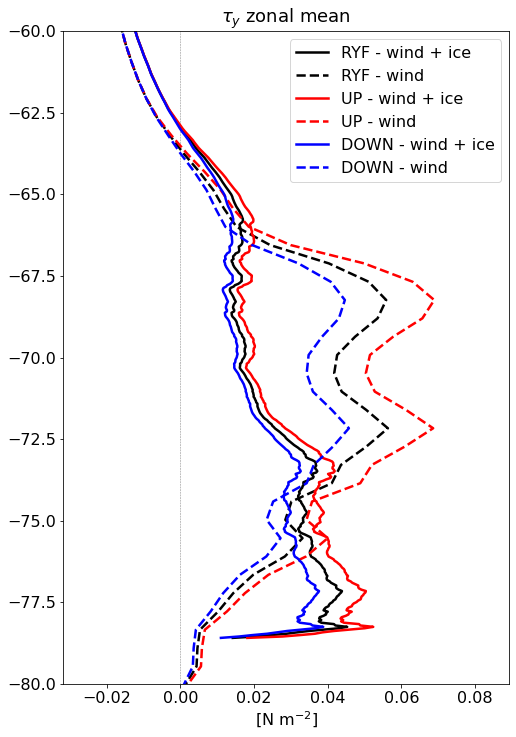

In [30]:
fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.plot(tau_ryf['tau_x'].mean('time').mean('xu_ocean'), tau_ryf['yu_ocean'], color = 'k', linewidth = 2.5, label = 'RYF - wind + ice')
axs.plot(tau_x['ryf'].mean('time').mean('longitude'), tau_x['ryf']['latitude'], color = 'k', linewidth = 2.5, linestyle = '--', label = 'RYF - wind')
axs.plot(tau_up['tau_x'].mean('time').mean('xu_ocean'), tau_up['yu_ocean'], color = 'r', linewidth = 2.5, label = 'UP - wind + ice')
axs.plot(tau_x['up'].mean('time').mean('longitude'), tau_x['up']['latitude'], color = 'r', linewidth = 2.5, linestyle = '--', label = 'UP - wind')
axs.plot(tau_down['tau_x'].mean('time').mean('xu_ocean'), tau_down['yu_ocean'], color = 'b', linewidth = 2.5, label = 'DOWN - wind + ice')
axs.plot(tau_x['down'].mean('time').mean('longitude'), tau_x['down']['latitude'], color = 'b', linewidth = 2.5, linestyle = '--', label = 'DOWN - wind')
axs.set_ylim(-80, -60)
axs.set_xlabel('[N m$^{-2}$]')
plt.legend()
plt.title('$\\tau_x$ zonal mean', fontsize = 18)
plt.savefig(figdir+'/easterlies-collaborative/tau_x_zonal_mean_wind.png')

fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.plot(tau_ryf['tau_y'].mean('time').mean('xu_ocean'), tau_ryf['yu_ocean'], color = 'k', linewidth = 2.5, label = 'RYF - wind + ice')
axs.plot(tau_y['ryf'].mean('time').mean('longitude'), tau_y['ryf']['latitude'], color = 'k', linewidth = 2.5, linestyle = '--', label = 'RYF - wind')
axs.plot(tau_up['tau_y'].mean('time').mean('xu_ocean'), tau_up['yu_ocean'], color = 'r', linewidth = 2.5, label = 'UP - wind + ice')
axs.plot(tau_y['up'].mean('time').mean('longitude'), tau_y['up']['latitude'], color = 'r', linewidth = 2.5, linestyle = '--', label = 'UP - wind')
axs.plot(tau_down['tau_y'].mean('time').mean('xu_ocean'), tau_down['yu_ocean'], color = 'b', linewidth = 2.5, label = 'DOWN - wind + ice')
axs.plot(tau_y['down'].mean('time').mean('longitude'), tau_y['down']['latitude'], color = 'b', linewidth = 2.5, linestyle = '--', label = 'DOWN - wind')
plt.title('$\\tau_y$ zonal mean', fontsize = 18)
axs.set_ylim(-80, -60)
axs.set_xlabel('[N m$^{-2}$]')
plt.legend()
plt.savefig(figdir+'/easterlies-collaborative/tau_y_zonal_mean_wind.png')